# Experiment with RNN

## Set paths, additional functions and import packages

**Set paths and functions**

In [5]:
root_logdir = '../Logs/'
data_dir = '../Data'
figs_dir = 'Figs/'
models_dir = '../Models/'

**Set functions**

In [6]:
# Tensorboard logs name generator
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

**Import packages**

In [7]:
import os
import time
import tensorflow as tf
import keras
from keras import models, layers
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import shuffle
from itertools import product
from tools import *
from tensorflow.keras import datasets, layers, models, losses, Model
import pickle
from generators import *
import sys 


In [8]:
from imblearn.metrics import sensitivity_specificity_support
%matplotlib notebook

In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


Num GPUs: 1


2022-10-11 12:09:22.719361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 12:09:22.778247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 12:09:22.778700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [10]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

## Load data

* X = 64 BSPs
* Y = labels (0-6) (Labels 6-7 are unified)
* Y_model = identifier of the AF model (1 to 13)

In [11]:

n_classes = 3 #1: Rotor/no rotor ; 2: RA/LA/No rotor (2 classes) ; 3: 7 regions (3 classes) + no rotor (8 classes)

X_1channel,Y,Y_model, egm_tensor=load_data(data_type='1channelTensor', n_classes=n_classes, subsampling= True, fs_sub=50, norm=False, SR=True, SNR=20)

['LA_LIPV_150119', 'LA_LSPV_150113', 'LA_LSPV_150203', 'LA_PLAW_140612', 'LA_PLAW_140711_arm', 'LA_RIPV_150121', 'LA_RSPV_150113', 'LA_RSPV_CAF_150115', 'RA_RAA_141216', 'RA_RAA_141230', 'RA_RAFW_140807', 'RA_RAFW_SAF_140730', 'Sinusal_150629', 'TwoRotors_181219']


In [12]:
fs=50

<IPython.core.display.Javascript object>


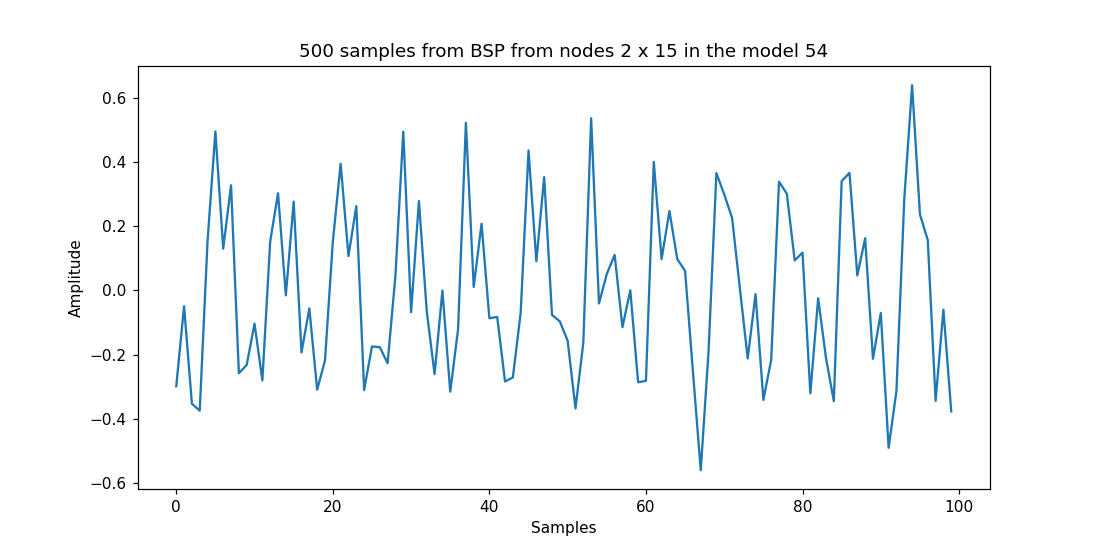

In [13]:
#Random signal visualizer: in each execution plots the first second of the BSPS in random nodes 
plt.figure(figsize=(10, 5))
a=randint(0, 5)
b=randint(0, 15)
s=randint(0, len(X_1channel)-501 )
title="500 samples from BSP from nodes {} x {} in the model {}".format(a,b,Y_model[s] )
plt.plot(X_1channel[s:s+100, a , b])
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title(title)
plt.show()

In [14]:
# EGM RESAMPLE -> CONSTELLATION

import scipy.io
constellation_nodes = scipy.io.loadmat('Constellation_nodes.mat')['constellation_nodes']
constellation_nodes=np.unique(constellation_nodes)
constellation_nodes_adjusted= [x-1 for x in constellation_nodes] #Restar 1 para ajustar índices matlab-python
egm_tensor_resampled= egm_tensor[:,constellation_nodes_adjusted]
print(egm_tensor_resampled.shape)


(289940, 126)


In [15]:
np.unique(Y_model)
len(Y_model)
count=0
for i in Y_model:
    if i==1:
        count+=1
print(count)



200


In [16]:
print(X_1channel.shape)

def define_image(time_instant, Tensor):
    image=Tensor[time_instant,: ,: ]
    return image
def define_frames(Tensor):
    ims = []
    for i in range(200):
        ims.append([Tensor[i, :, :]])
    return ims
    
        
    


(29000, 6, 16)


plt.figure()
image=define_image(5,X_1channel )
plt.imshow(image, cmap='jet')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


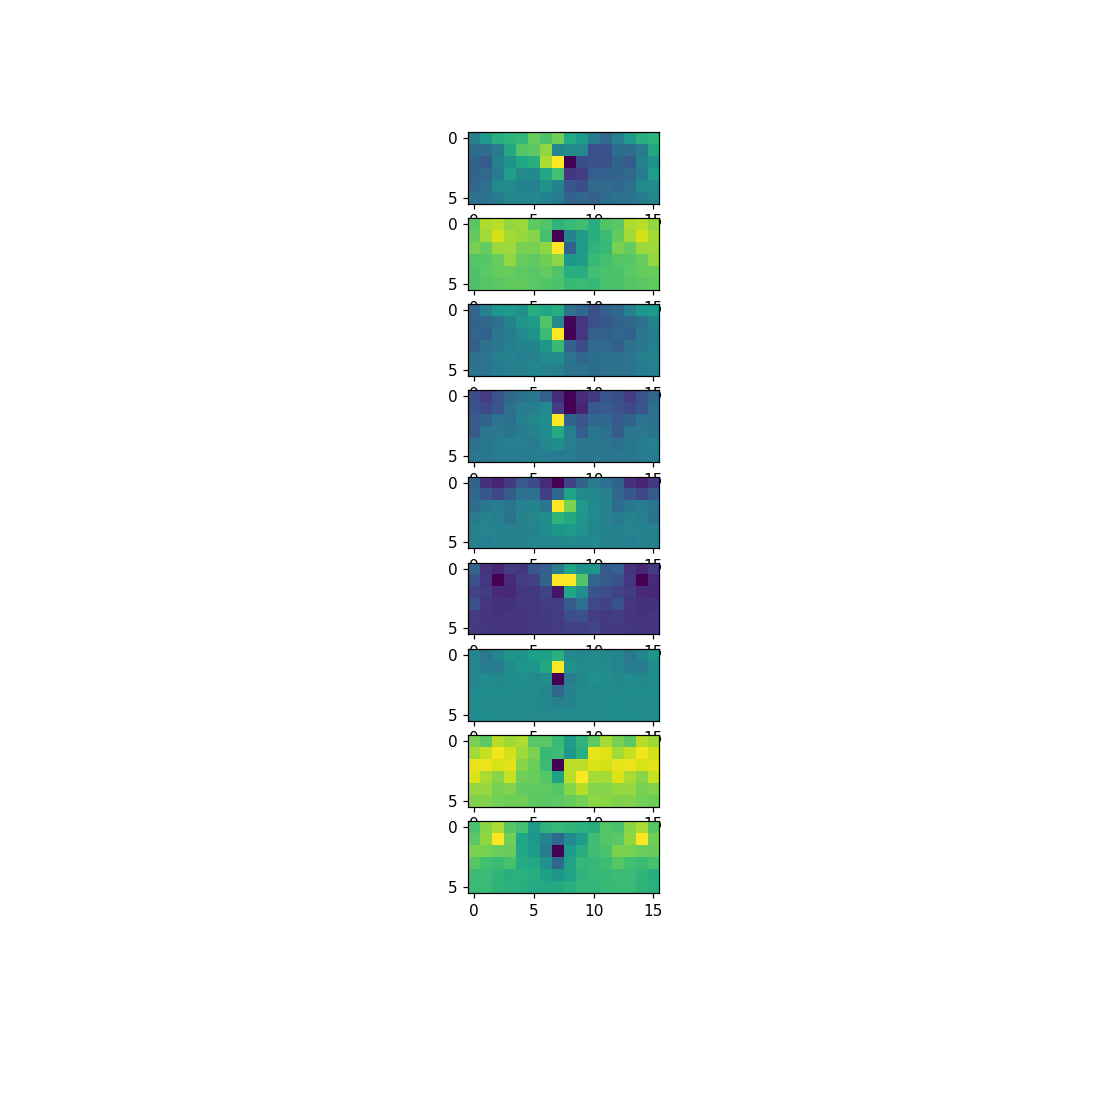

In [17]:
plt.figure(figsize=(10, 10))
for i in range(1,10):
    image=define_image(i, X_1channel)
    plt.subplot(10, 1, i)
    plt.imshow(image) #map='jet')
plt.show()




In [18]:
# Train/Test/Val Split 
'''
1-8 AF Models --> Train
9-11 AF Models --> Test
12-13 AF Models --> Val
'''
x_train=X_1channel[np.where((Y_model>=1) & (Y_model<=80))]
x_test=X_1channel[np.where((Y_model>80) & (Y_model<=110))]
x_val=X_1channel[np.where((Y_model>110) & (Y_model<=130))]
y_train=egm_tensor[np.where((Y_model>=1) & (Y_model<=80))]
y_test=egm_tensor[np.where((Y_model>80) & (Y_model<=110))]
y_val=egm_tensor[np.where((Y_model>110) & (Y_model<=130))]
print(x_train.shape, x_test.shape, x_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(17500, 6, 16) (6500, 6, 16) (5000, 6, 16)
(17500, 2048) (6500, 2048) (5000, 2048)


In [19]:
y_train=egm_tensor_resampled[np.where((Y_model>=1) & (Y_model<=80))]
y_test=egm_tensor_resampled[np.where((Y_model>80) & (Y_model<=110))]
y_val=egm_tensor_resampled[np.where((Y_model>110) & (Y_model<=130))]
print(x_train.shape, x_test.shape, x_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(17500, 6, 16) (6500, 6, 16) (5000, 6, 16)
(17500, 126) (6500, 126) (5000, 126)


(17500, 6, 16) (6500, 6, 16) (5000, 6, 16)
(17500, 6, 16, 1) (6500, 6, 16, 1) (5000, 6, 16, 1)
(17500, 12, 32, 1) (6500, 12, 32, 1)


2022-10-11 12:11:13.285550: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 12:11:13.286326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 12:11:13.286777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 12:11:13.287122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

<IPython.core.display.Javascript object>


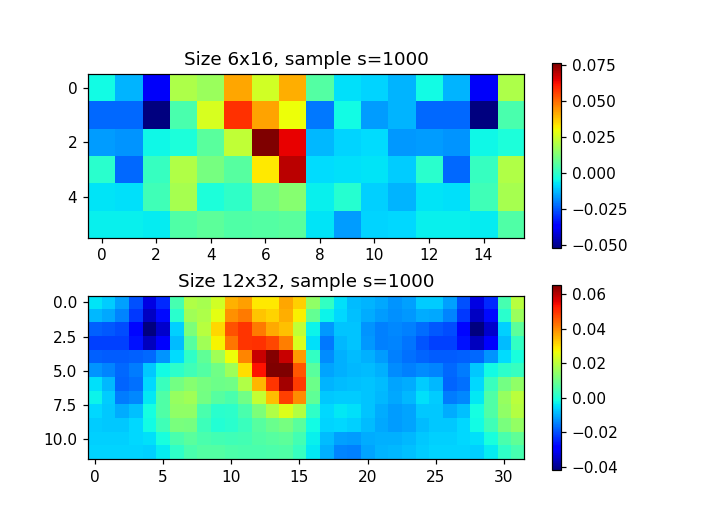

In [20]:
from numpy import reshape
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

'''
#Divide train, val and test
x_train= X_1channel[0:int(len(X_1channel)*0.7), :]
x_test= X_1channel[int(len(X_1channel)*0.7)+1:int(len(X_1channel)*0.7)+1+int(len(X_1channel)*0.25), :, :]
x_val= X_1channel[int(len(X_1channel)*0.7)+1+int(len(X_1channel)*0.25):-1, :, :]
x_train_or, x_test_or, x_val_or=x_train, x_test, x_val
'''

'''
#Standardization
scalers = {}
for i in range(x_train.shape[1]):
    scalers[i] = StandardScaler()
    x_train[:, i, :] = scalers[i].fit_transform(x_train[:, i, :]) 

for i in range(x_test.shape[1]):
    x_test[:, i, :] = scalers[i].transform(x_test[:, i, :]) 
    
for i in range(x_val.shape[1]):
    x_val[:, i, :] = scalers[i].transform(x_val[:, i, :]) 
x_train_st=x_train


#Standardization
scalers = {}
for i in range(y_train.shape[1]):
    scalers[i] = StandardScaler()
    y_train[:, i, :] = scalers[i].fit_transform(y_train[:, i, :]) 

for i in range(y_test.shape[1]):
    y_test[:, i, :] = scalers[i].transform(y_test[:, i, :]) 
    
for i in range(x_val.shape[1]):
    y_val[:, i, :] = scalers[i].transform(y_val[:, i, :]) 
x_train_st=x_train
'''
x_train_or, x_test_or, x_val_or=x_train, x_test, x_val

#Reshape for interpolation
print(x_train.shape, x_test.shape, x_val.shape) 
x_train = reshape(x_train, (len(x_train), 6, 16,1)) 
x_test = reshape(x_test, (len(x_test), 6, 16,1))
x_val = reshape(x_val, (len(x_val), 6, 16,1))
print(x_train.shape, x_test.shape, x_val.shape) 

#Interpolation
x_train = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x_train)
x_test = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x_test)
x_val = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x_val)
print(x_train.shape, x_test.shape) 

#Plot
plt.figure()
plt.subplot(2,1,1)
image=define_image(1000,x_train_or)
plt.imshow(image, cmap='jet')
plt.title('Size 6x16, sample s=1000')
plt.colorbar()

plt.subplot(2,1,2)
image=define_image(1000,x_train )
plt.imshow(image, cmap='jet')
plt.title('Size 12x32, sample s=1000')
plt.colorbar()
plt.show()

plt.figure()
image=define_image(1000,x_train )
plt.imshow(image, cmap='jet')
plt.title('Size 12x32, sample s=1000')
plt.colorbar()
plt.show()

# Autoencoder model

# Clear previous keras models

model = models.Sequential()
model.add(tf.keras.layers.Reshape((2,25,64), input_shape=(input_size,64)))
model.add(layers.TimeDistributed(layers.Conv2D(32, (2, 2), strides=1, padding='same',
                                               activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=5)))
model.add(layers.TimeDistributed(layers.Conv1D(filters=32, kernel_size=3)))
model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=3)))
model.add(layers.TimeDistributed(layers.Flatten()))
#model.add(layers.Dropout(0.8))
model.add(layers.LSTM(30))
model.add(attention())
#model.add(layers.Dropout(0.8))
#model.add(layers.Dense(n_labels, activation= 'softmax' ))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc',tfa.metrics.CohenKappa(num_classes=n_labels)])
  
# Check summary of model    
model.summary()

In [25]:
x_train.shape[1:]

TensorShape([12, 32, 1])

In [81]:
encoder = models.Sequential()
encoder.add(layers.TimeDistributed(layers.Conv2D(32, (2, 2), strides=1, padding='same',activation='relu')
                                   , input_shape=(1, 50, 12, 32)))
encoder.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
#encoder.add(layers.Dropout(0.2))
encoder.add(layers.TimeDistributed(layers.Conv2D(12, (2, 2), strides=1, padding='same', activation='relu')))
encoder.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
encoder.add(layers.TimeDistributed(layers.Conv2D(12, (2, 2), strides=1, padding='same', activation='relu')))
encoder.add(layers.TimeDistributed(layers.MaxPooling2D((1, 2))))
encoder.add(layers.TimeDistributed(layers.Flatten()))
encoder.add(layers.LSTM(144, return_sequences=True))
#encoder.build((12, 32, 1)) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
encoder.summary()


Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_178 (TimeD  (None, 1, 50, 12, 32)    4128      
 istributed)                                                     
                                                                 
 time_distributed_179 (TimeD  (None, 1, 25, 6, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_180 (TimeD  (None, 1, 25, 6, 12)     1548      
 istributed)                                                     
                                                                 
 time_distributed_181 (TimeD  (None, 1, 12, 3, 12)     0         
 istributed)                                                     
                                                                 
 time_distributed_182 (TimeD  (None, 1, 12, 3, 12)   

In [79]:
decoder = models.Sequential()
decoder.add(layers.Reshape((None, 50, 3, 4, 12), input_shape=encoder.output.shape[1:]))
decoder.add(layers.TimeDistributed(layers.Conv2D(12, (2,2), strides=1, padding='same',
                                                 activation='relu')))
decoder.add(layers.TimeDistributed(layers.UpSampling2D((1, 2))))
decoder.add(layers.TimeDistributed(layers.Conv2D(12, (2,2), strides=1, padding='same', activation='relu')))
decoder.add(layers.TimeDistributed(layers.UpSampling2D((2, 2))))
decoder.add(layers.Dropout(0.2))
decoder.add(layers.TimeDistributed(layers.Conv2D(32, (2,2), strides=1, padding='same', activation='relu')))
decoder.add(layers.TimeDistributed(layers.UpSampling2D((2, 2))))
decoder.add(layers.TimeDistributed(layers.Conv2D(1, (2,2), strides=1, padding='same', activation='linear')))
decoder.summary()

ValueError: Exception encountered when calling layer "reshape_26" (type Reshape).

Tried to convert 'shape' to a tensor and failed. Error: None values not supported.

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 144), dtype=float32)

In [72]:
conv_autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.outputs))
conv_autoencoder.compile(optimizer='adam', loss=losses.mean_squared_error)
history = conv_autoencoder.fit(x_train, x_train, batch_size=50, epochs=20, validation_data=(x_val, x_val))

Epoch 1/20


ValueError: in user code:

    File "/home/mgutierrez/anaconda3/envs/Research/lib/python3.10/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/mgutierrez/anaconda3/envs/Research/lib/python3.10/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mgutierrez/anaconda3/envs/Research/lib/python3.10/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/mgutierrez/anaconda3/envs/Research/lib/python3.10/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/mgutierrez/anaconda3/envs/Research/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/mgutierrez/anaconda3/envs/Research/lib/python3.10/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 50, 12, 32, 1), found shape=(50, 12, 32, 1)


In [31]:
decoded_imgs = conv_autoencoder.predict(x_test)
print(decoded_imgs.shape, x_test.shape)
decoded_imgs = reshape(decoded_imgs, (len(decoded_imgs), decoded_imgs.shape[1],  decoded_imgs.shape[2]))
x_test = reshape(x_test, (len(x_test),x_test.shape[1],  x_test.shape[2])) 
print(decoded_imgs.shape, x_test.shape)

(6500, 12, 32, 1) (6500, 12, 32, 1)
(6500, 12, 32) (6500, 12, 32)


<IPython.core.display.Javascript object>


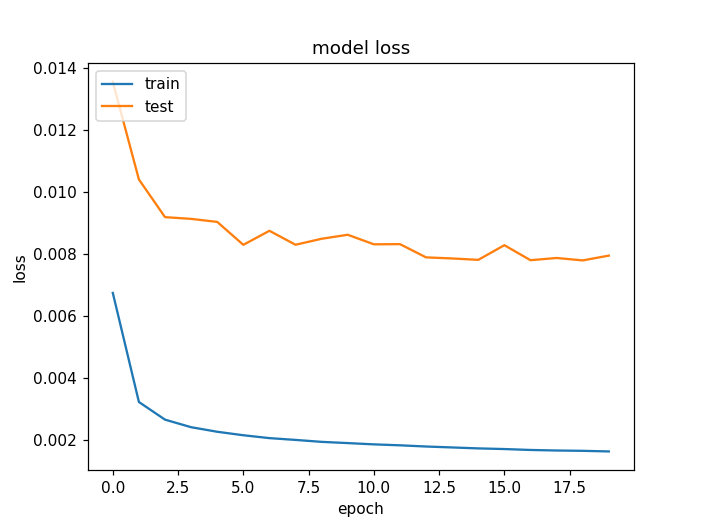

In [32]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


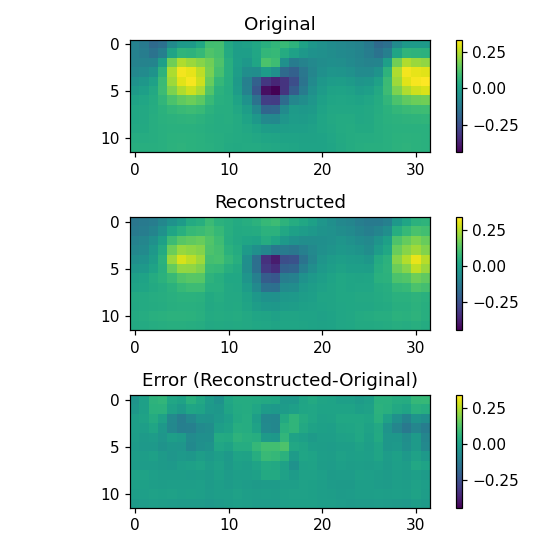

In [33]:
time_instant= 550

plt.figure(figsize=(5,5), layout='tight')
plt.subplot(3,1,1)
image1=define_image(time_instant,x_test )
min_val, max_val = np.amin(image1), np.amax(image1)
plt.imshow(image1, vmin=min_val, vmax=max_val)#, cmap='jet')
plt.colorbar()
plt.title('Original')
plt.subplot(3,1,2)
image2=define_image(time_instant,decoded_imgs)
plt.imshow(image2, vmin=min_val, vmax=max_val) #, cmap='jet')
plt.colorbar()
plt.title('Reconstructed')
plt.subplot(3,1,3)
plt.imshow(image2-image1, vmin=min_val, vmax=max_val)
plt.title('Error (Reconstructed-Original)')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


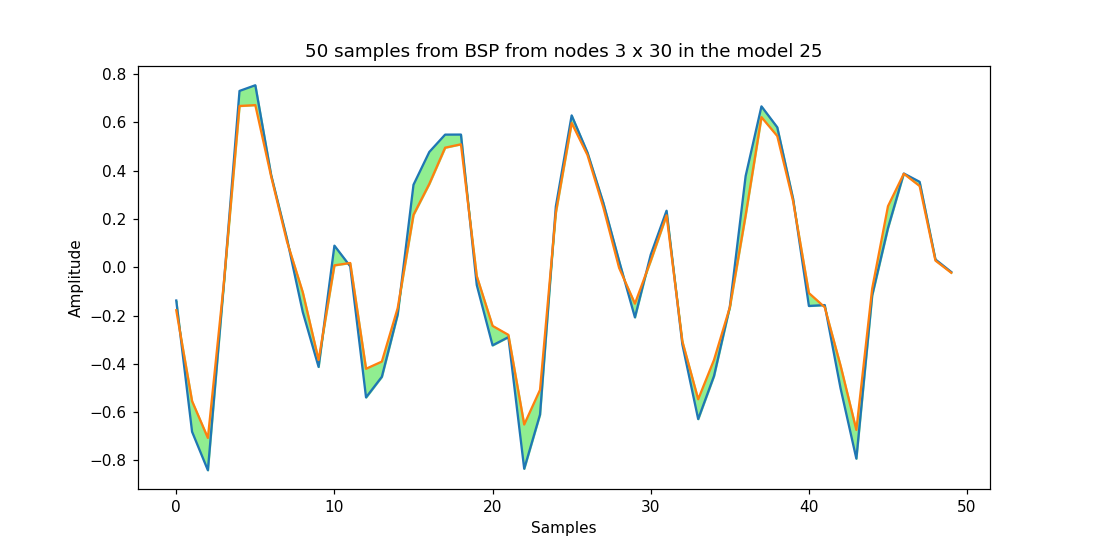

In [43]:
'''
plt.figure(figsize=(10, 5))
plt.plot(x_test[0:fs, 1, 1], label=('Input'))
plt.plot(decoded_imgs[0:fs, 1, 1], label=('Reconstruction'))
plt.fill_between(np.arange(fs), decoded_imgs[0:fs, 1, 1],x_test[0:fs, 1, 1], color='lightgreen')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()
'''
#Random signal visualizer: in each execution plots the first second of the BSPS in random nodes 
plt.figure(figsize=(10, 5))
a=randint(0, decoded_imgs.shape[1]-1)
b=randint(0, decoded_imgs.shape[2]-1)
s=randint(0, len(decoded_imgs)-fs-1 )
title="50 samples from BSP from nodes {} x {} in the model {}".format(a,b,Y_model[s] )
plt.plot(x_test[s:s+fs, a , b], label=('Input'))
plt.plot(decoded_imgs[s:s+fs, a , b], label=('Reconstruction'))
plt.fill_between(np.arange(fs), decoded_imgs[s:s+fs, a , b],x_test[s:s+fs, a , b], color='lightgreen')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title(title)
plt.show()

# Latent Space 

In [44]:
latent_vector = encoder.predict(x_test)


In [45]:
latent_vector.shape

(6500, 3, 4, 12)

plt.figure(figsize=(10, 5))
plt.plot(latent_vector[0:100, 1, 2], label=('Input'))
plt.legend(labels=["Input"])
plt.show()

<IPython.core.display.Javascript object>


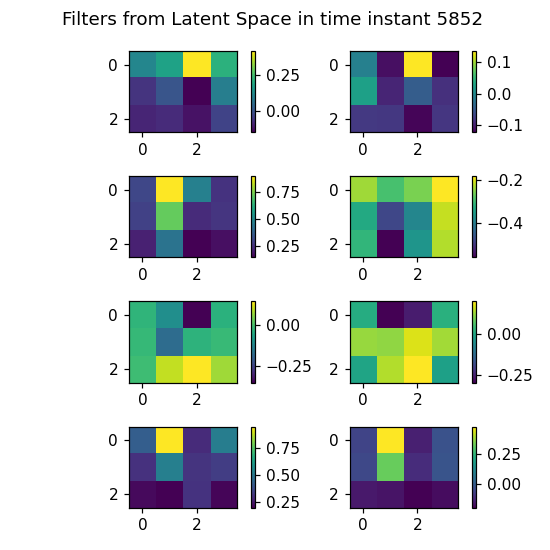

In [54]:
time_instant= randint(0, len(decoded_imgs)-fs-1 )
plt.figure(figsize=(5,5), layout='tight')
title="Filters from Latent Space in time instant {} ".format(time_instant)
for i in range (0,8):
    plt.subplot(4, 2, i+1)
    #plt.plot(6, 2, i) 
    plt.imshow(latent_vector[time_instant, :, :,i])#, cmap='jet')
    plt.colorbar()
plt.suptitle(title)

plt.show()

<IPython.core.display.Javascript object>


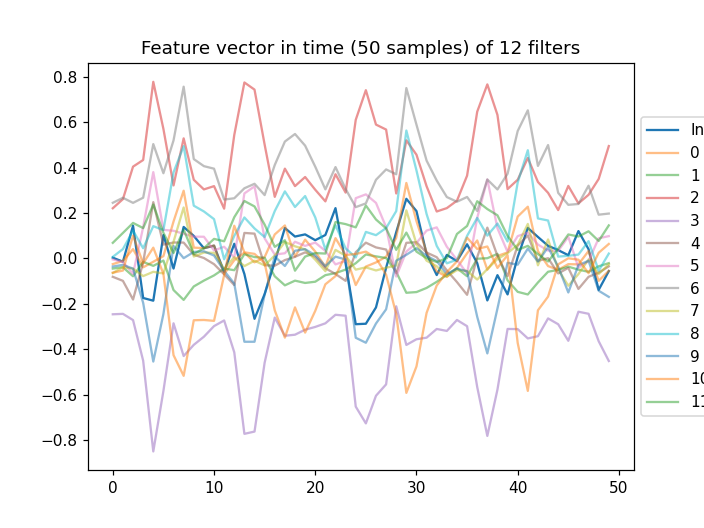

In [65]:
plt.figure()
plt.plot(x_test[0:50, 1, 1], label ='Input')#, cmap='jet')

for i in range (0,12):
    #plt.plot(6, 2, i) 
    plt.plot(latent_vector[0:50, 1, 1,i], alpha=0.5,  label=i)#, cmap='jet')
    plt.title('Feature vector in time (50 samples) of 12 filters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Estimation EGM

In [28]:
sys.exit()

SystemExit: 

/home/mgutierrez/anaconda3/envs/Research/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3532: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#Input
latent_vector_train = encoder.predict(x_train)
latent_vector_test= encoder.predict(x_test)
latent_vector_val = encoder.predict(x_val)
print(latent_vector_train.shape, y_train.shape)
print(latent_vector_test.shape, y_test.shape)
print(latent_vector_val.shape, y_val.shape)
print(latent_vector_train.shape[1:])

In [ ]:
estimator =models.Sequential()
estimator.add(layers.Conv2D(12, (2,2), strides=1, padding='same', activation='relu', input_shape=latent_vector_train.shape[1:]))
estimator.add(layers.UpSampling2D((4, 4)))
estimator.add(layers.Conv2D(12, (2,2), strides=1, padding='same', activation='relu'))
estimator.add(layers.UpSampling2D((4, 4)))
estimator.add(layers.Conv2D(12, (2,2), strides=1, padding='same', activation='relu'))
estimator.add(layers.UpSampling2D((4, 4)))
estimator.add(layers.Flatten())
decoder.add(layers.Dropout(0.2))
estimator.add(layers.Dense(egm_tensor_resampled.shape[1], activation='relu'))
estimator.summary()



In [ ]:
estimator.compile(optimizer='adam', loss=losses.mean_squared_error)
history = estimator.fit(latent_vector_train, y_train, batch_size=100, epochs=30, validation_data=(latent_vector_val, y_val))

In [ ]:
latent_vector_val.shape